---
## <center>*Data Challenge*</center>
# **<center>Facial Expression Recognition in Image Sequences</center>**
---
> **Team:** Atlas

> **Members:** Yassin El Hajj CHehade & Omar Iken
---

### ◼ __Overview__
The goal of this challenge is to develop an algorithm for recognizing facial expressions from video sequences. Each sequence corresponds to an expression, among the following Ekman's six universal expressions: anger, surprise, disgust, happiness, fear and sadness.
In addition to the images, you can use distributions of characteristic points (called facial landmarks) to analyze facial expressions. Each landmark corresponds to a specific region of the face (e.g. corner of the mouth). Each image contains 68 landmarks, 

### ■ **<a name="content">Contents</a>**


- [1. Dataset](#section1)

- [2. Landmarks-based approaches](#section2)

    - [2.1. Random Forest](#)
    
    - [2.2. Landmarks to signals + CNN](#)
    
    - [2.3. Landmarks to images + Conv3D](#)
    
    - [2.4. PCA + Random Forest](#)
    
- [3. Image-based approaches](#section3)

    - [3.1. CNN + Last image in sequence](#)

    - [3.2. Rescaled images + Conv3D](#)
    
    - [3.3. Optical Flow + Conv3D](#)
    

- [5. Perspectives](#section4)


### ■ **<a name="libraries">Libraries</a>** [(&#8593;)](#content)
---

In [1]:
## tf dependencies
import tensorflow as tf
from keras.layers import LSTM,Dropout,Dense,TimeDistributed,Conv1D,MaxPooling1D,Flatten

## sklearn dependecies
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

## to ompute preprocess optical flow
import sys
import os

## to hadle dataframes
import pandas as pd
import h5py

## to handle arrays & matrices
import numpy as np

## to plot figures & images
import seaborn as sns
import matplotlib.pyplot as plt
import cv2

## to show the progress of the training
from tqdm import tqdm
import pathlib
import time
import datetime
from IPython import display

In [2]:
## ----------< Settings >-----------------
plt.rcParams['figure.figsize'] = (14, 5)
sns.set(font_scale=1.2, style='whitegrid')

## dependencies versions
print(f"> tensorflow version: {tf.__version__}")
print(f"> numpy version     : {np.__version__}")
print(f"> opencv version    : {cv2.__version__}")

> tensorflow version: 2.6.2
> numpy version     : 1.20.3
> opencv version    : 4.5.4



### ■ **<a name="preliminaries">Preliminaries</a>** [(&#8593;)](#content)
---

In [3]:
def create_submission_file(predictions, fname="sampleSubmission.csv"):
    """to put predictions into a csv file to submit"""
    df = pd.DataFrame(predictions, columns=['expression']).astype('int')
    df.index.name = 'Id'
    df.to_csv(fname)

### ■ **<a name="section1">1. Dataset</a>** [(&#8593;)](#content)
---
#### **1.1. Load & read data**
Let's start by uploading our dataset !

In [4]:
## train & test data file names
landmarks_train_fname = '/kaggle/input/fer22/data_train_landmarks.h5'
labels_train_fname = '/kaggle/input/fer22/data_train_labels.h5'
images_train_fname = '/kaggle/input/fer22/data_train_images.h5'
landmarks_test_fname = '/kaggle/input/fer22/data_test_landmarks.h5'
images_test_fname = '/kaggle/input/fer22/data_test_images.h5'

# ## read data
h5f = h5py.File(images_train_fname,'r')
train_images = h5f['data_train_images'][:]
h5f = h5py.File(landmarks_train_fname, 'r')
train_landmarks = h5f['data_train_landmarks'][:]
h5f = h5py.File(labels_train_fname, 'r')
train_labels = h5f['data_train_labels'][:]
h5f = h5py.File(images_test_fname, 'r')
test_images = h5f['data_test_images'][:]
h5f = h5py.File(landmarks_test_fname, 'r')
test_landmarks = h5f['data_test_landmarks'][:]
h5f.close()

## data shape
n_train, n_seq, *img_shape = train_images.shape

## data info
print(f'> Number of training samples: {train_landmarks.shape[0]}')
print(f'> Number of testing samples : {test_landmarks.shape[0]}')
print(f'> Number of Landmarks       : {train_landmarks.shape[2]}')
print(f'> Number of sequences       : {train_landmarks.shape[1]}')
print(f'> Images shape              : {(train_images.shape[2], train_images.shape[3])}')
print(f'> Landmarks shape           : {(train_landmarks.shape[2], train_landmarks.shape[3])}')
print(f'> Number of classes         : {len(np.unique(train_labels))}')

> Number of training samples: 540
> Number of testing samples : 131
> Number of Landmarks       : 68
> Number of sequences       : 10
> Images shape              : (300, 200)
> Landmarks shape           : (68, 2)
> Number of classes         : 6


#### **1.2. Expressions Stats**
We explore the dataset in terms of subjects, expressions, etc.

In [5]:
## store different expressions
expressions = ['happiness','fear','surprise','anger','disgust','sadness']
n_expressions = len(expressions)

## encode expressions
expressions_dict = dict(zip(range(n_expressions), expressions))
expressions_dict

{0: 'happiness',
 1: 'fear',
 2: 'surprise',
 3: 'anger',
 4: 'disgust',
 5: 'sadness'}

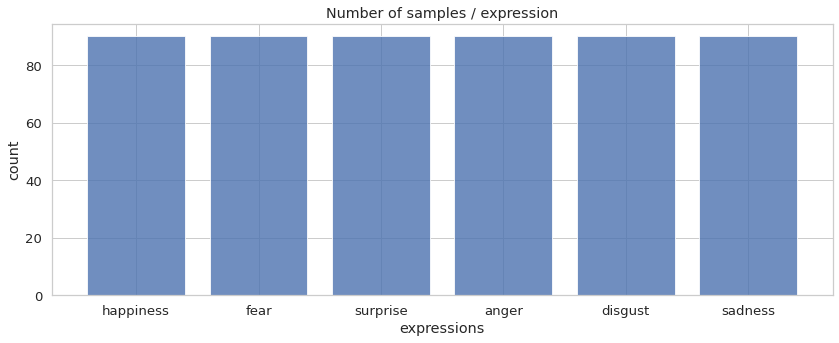

In [6]:
## plot histograms & pies for expressions
labels, counts = np.unique(train_labels, return_counts=True)
labels = [expressions_dict.get(label) for label in labels]
fig, ax = plt.subplots()
ax.bar(labels, counts, alpha=.8)
ax.set_xlabel('expressions')
ax.set_ylabel('count')
ax.set_title('Number of samples / expression')
plt.show()

>**Comment:** the data is balanced in terms of expressions !

#### **1.3. Display some Sequences**

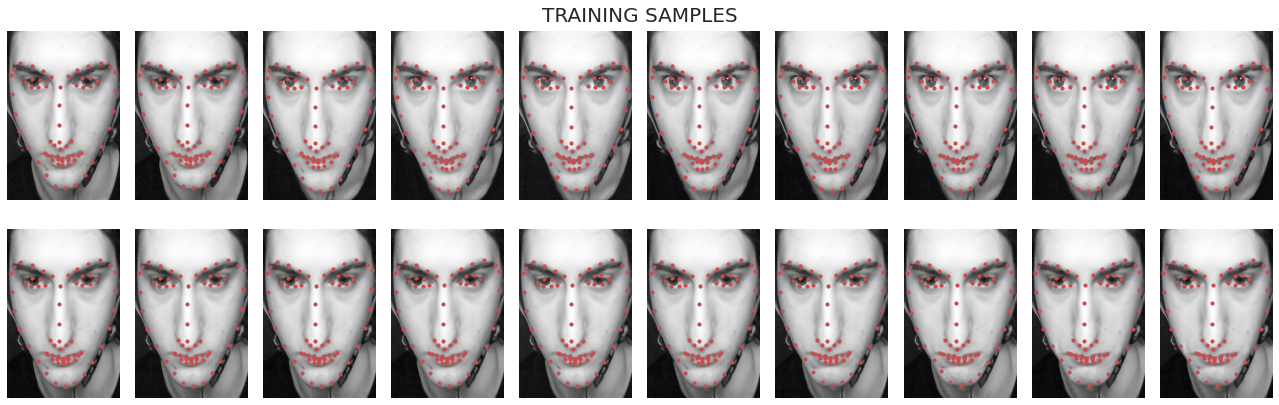

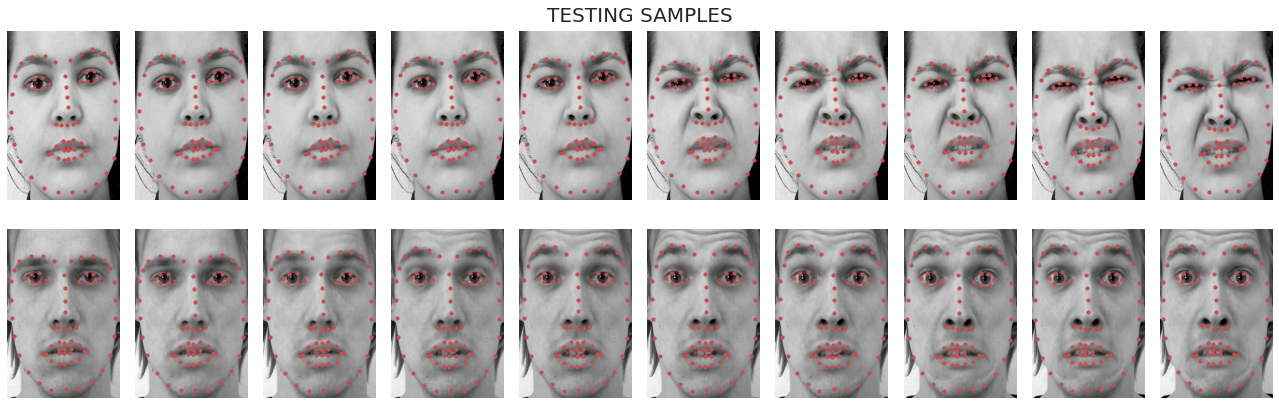

In [7]:
## pick random sequences
rdm_idx = sorted(np.random.randint(n_train, size=2))
rdm_seq = train_images[rdm_idx, ...]
rdm_landmarks = train_landmarks[rdm_idx, ...]

## display
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(18, 6))
for seq, lands, ax_row in zip(rdm_seq, rdm_landmarks, axes):
    for e, ax in enumerate(ax_row):
        ax.imshow(seq[e], cmap='gray')
        ax.scatter(lands[e][:, 0], lands[e][:, 1], c='r', s=10)
        ax.axis('off')
fig.tight_layout()
plt.suptitle('TRAINING SAMPLES', fontsize=20)
plt.show()

## display
rdm_idx = sorted(np.random.randint(len(test_images), size=2))
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(18, 6))
for seq, lands, ax_row in zip(test_images[rdm_idx], test_landmarks[rdm_idx], axes):
    for e, ax in enumerate(ax_row):
        ax.imshow(seq[e], cmap='gray')
        ax.scatter(lands[e][:, 0], lands[e][:, 1], c='r', s=10)
        ax.axis('off')
fig.tight_layout()
plt.suptitle('TESTING SAMPLES', fontsize=20)
plt.show()

>**Comment:** different brightness & contrast levels between training and testing samples.

### ■ **<a name="section2">2. Landmarks-based approaches</a>** [(&#8593;)](#content)
---
#### **2.1. Random Forest Classification**
THis first approach consists of using a random forest classifier on the landmarks.

In [8]:
## extract x & y coordinates of landmarks
x_coords = train_landmarks[:, -1, :, 0]
y_coords = train_landmarks[:, -1, :, 1]
x_coords_test = test_landmarks[:, -1, :, 0]
y_coords_test = test_landmarks[:, -1, :, 1]

## put coordinates in 2D array
X = np.hstack((x_coords, y_coords))
X_test = np.hstack((x_coords_test, y_coords_test))

## split the data & make sure expressions are balanced (stratify)
X_train, X_val, y_train, y_val = train_test_split(X, train_labels, test_size=0.2, random_state=42, stratify=train_labels)
print(f'> Number of training samples  : {X_train.shape[0]}')
print(f'> Number of validation samples: {X_val.shape[0]}')

> Number of training samples  : 432
> Number of validation samples: 108


>**Note:** When splitting the data, we have to take into consideration the fact that a subject can be part of both training and validation sets, which is not the case for the test set. Therefore, the score on the validation set do not quantify the score on the test set.

In [9]:
## create & fit a random forest classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

## make & save predictions & evaltuate model
predictions = clf.predict(X_test)
create_submission_file(predictions)

print(f'Accuracy: {clf.score(X_val, y_val)}')

Accuracy: 0.7685185185185185


>**Comment:** surprising results for such simple model !

#### **2.2. Landmarks to signals + CNN**
For this second approach, we porpose to use an LSTM on the landmarks, by modeling them in a time series way. In fact, we will extract the variation of each landmark over sequences, and then fit them to an LSTM model.

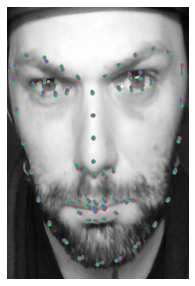

In [10]:
def model_landmarks_signal(seq):
    """return variation of landmarks between sequences as signals"""
    signals = []
    for i in range(1, len(seq)):
        delta = []
        prev, curt = seq[i-1], seq[i]
        for a, b in zip(prev, curt):
            ## compute distance
            d = np.sqrt((b[1] - a[1]) ** 2 + (b[0] - a[0]) ** 2)
            delta.append(d)
        signals.append(delta)
    return np.array(signals)

def plot_arrows_on_landmarks(image, landmarks_1, landmarks_2):
    """to plot arrows refering to variation of landmarks locations"""
    
    fig, ax = plt.subplots()
    ax.imshow(image, cmap='gray')
    ax.scatter(landmarks_2[:, 0], landmarks_2[:, 1], c='r', s=10)
    ax.scatter(landmarks_1[:, 0], landmarks_1[:, 1], c='g', s=10)    
    for (x1, y1), (x2, y2) in zip(landmarks_1, landmarks_2):
        ax.arrow(x1, y1, x2-x1, y2-y1, width = 0.5, color="b")
    ax.axis('off')
    plt.show()

## diaplay landmarks variation
plot_arrows_on_landmarks(train_images[10][-1], train_landmarks[10][0], train_landmarks[10][-1])

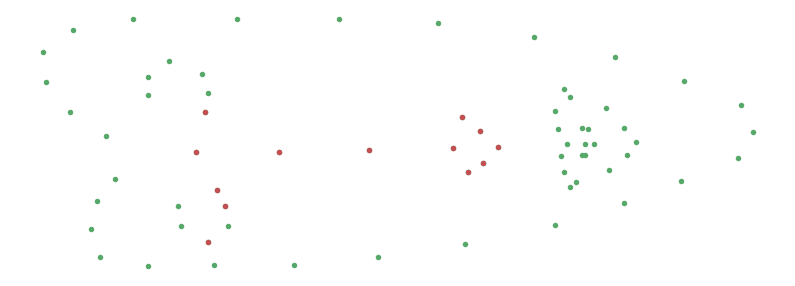

Number of significatn landmarks: 55


In [11]:
def get_non_sig_landmarks(landmarks, std, show=False):
    """return non significant landmarks, i.e., landmarks that do not varie much
    Def: a landmark is non significant if it standard deviation is < std.
    """

    
    sigs = np.array([model_landmarks_signal(seq) for seq in train_landmarks])
    non_sig_idx = np.where(np.std(sigs, axis=0).mean(axis=0) < std)

    if show:
        rdm_idx = np.random.randint(len(landmarks))
        fig, ax = plt.subplots()
        ax.scatter(landmarks[rdm_idx, 0, :, 1], landmarks[rdm_idx, 0, :, 0], c='g', s=20)
        ax.scatter(landmarks[rdm_idx, 0, non_sig_idx, 1], landmarks[rdm_idx, 0, non_sig_idx, 0], c='r', s=20) 
        ax.axis('off')
        plt.show()

    return np.delete(range(landmarks.shape[2]), non_sig_idx)

## get & display non significant landmarks
sig_idx = get_non_sig_landmarks(train_landmarks, std=1.1, show=True)
print(f'Number of significatn landmarks: {len(sig_idx)}')

>**Comment:** the landmarks on the nose, and some around the eyes have small variation, therefore, there less significant to affect the expressions.

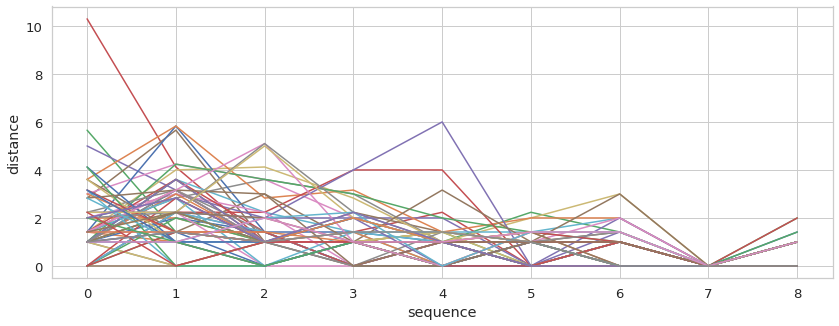

In [12]:
plt.plot(model_landmarks_signal(train_landmarks[-1]))
plt.xlabel('sequence')
plt.ylabel('distance')
plt.show()

In [13]:
## compute significant landmarks signals
X = np.array([model_landmarks_signal(seq) for seq in train_landmarks[:, :, sig_idx, :]])
X_test = np.array([model_landmarks_signal(seq) for seq in test_landmarks[:, :, sig_idx, :]])

## onehot encoding
y = tf.keras.utils.to_categorical(train_labels, num_classes=n_expressions)

## split the data & make sure expressions are balanced (stratify)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=train_labels)
print(f'> Number of training samples  : {X_train.shape[0]}')
print(f'> Number of validation samples: {X_val.shape[0]}')

## expand dimensions
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

> Number of training samples  : 432
> Number of validation samples: 108


In [14]:
def build_model(input_shape, n_classes):
    """to build a model"""

    model = tf.keras.models.Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=input_shape))
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(Dropout(0.5)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(512))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(n_classes, activation='sigmoid'))

    return model

_, *input_shape = X_train.shape
model = build_model(input_shape, n_expressions)
model.compile(optimizer = tf.keras.optimizers.Adam(0.001), 
                loss = 'categorical_crossentropy', 
                metrics = ['accuracy'])

model.summary()

2022-02-25 16:50:36.244280: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 9, 53, 64)         256       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 9, 51, 64)         12352     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 9, 51, 64)         0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 9, 25, 64)         0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 9, 1600)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 512)               4327424   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0

2022-02-25 16:50:37.121561: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
4/4 [==============================] - 5s 619ms/step - loss: 1.8383 - accuracy: 0.1736 - val_loss: 1.7886 - val_accuracy: 0.1667
Epoch 2/20
4/4 [==============================] - 2s 418ms/step - loss: 1.7812 - accuracy: 0.2060 - val_loss: 1.7287 - val_accuracy: 0.2685
Epoch 3/20
4/4 [==============================] - 2s 400ms/step - loss: 1.7636 - accuracy: 0.2384 - val_loss: 1.6775 - val_accuracy: 0.2407
Epoch 4/20
4/4 [==============================] - 2s 399ms/step - loss: 1.6541 - accuracy: 0.3171 - val_loss: 1.6240 - val_accuracy: 0.2407
Epoch 5/20
4/4 [==============================] - 2s 405ms/step - loss: 1.6554 - accuracy: 0.2778 - val_loss: 1.5983 - val_accuracy: 0.3333
Epoch 6/20
4/4 [==============================] - 2s 397ms/step - loss: 1.6052 - accuracy: 0.2986 - val_loss: 1.4965 - val_accuracy: 0.4352
Epoch 7/20
4/4 [==============================] - 2s 401ms/step - loss: 1.5421 - accuracy: 0.3356 - val_loss: 1.4805 - val_accuracy: 0.3981
Epoch 8/20
4/4 [====

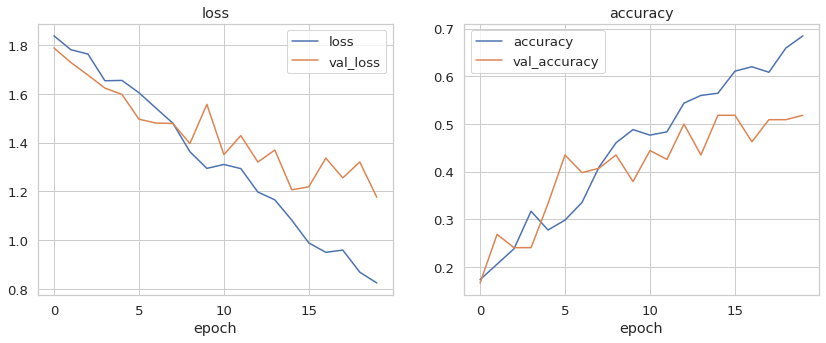

In [15]:
## fit and evaluate model
n_epochs = 20
batch_size = 128

history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val),
                    epochs=n_epochs, batch_size=batch_size)

## plot accuracy & loss
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(ax=ax1, xlabel='epoch', title='loss')
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(ax=ax2, xlabel='epoch', title='accuracy')
plt.show()

## make & save predictions
predictions = np.argmax(model.predict(X_test), axis=1)
create_submission_file(predictions)

>**Comment:** Still need more improvements !

#### **2.3. Landmarks to images + Conv3D**
This third approach is very simple, as it consists of transforming landmakrs coordinates into images, and then use a Conv3D CNN.

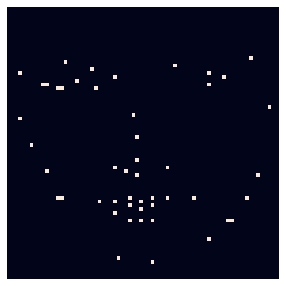

In [16]:
def landmarks_to_image(landmarks, w, h, ksize):
    """transform landmarks to images"""
    image = np.zeros((h, w))
    dirs = [(0, 0), (0, -1), (0, 1), (1, 0), (1, -1), (1, 1), (-1, 0), (-1, 1), (-1, -1)]
    for x, y in landmarks:
        for d in dirs:
            image[y + d[1], x + d[0]] = 1.
    image = cv2.resize(image, ksize,interpolation = cv2.INTER_NEAREST)
    return image

## display an example
plt.imshow(landmarks_to_image(train_landmarks[0][-1], 200, 300, (72, 72)))
plt.axis('off')
plt.show()

>**Note:** we will be using low resolution images (we think that High resolution images with small number of landmakrs will affect dramatically the performance of the model.

In [17]:
## landmarks to images
ksize = (72, 72)
X = np.array([[landmarks_to_image(landmarks, img_shape[-1], img_shape[0], ksize) for landmarks in seq] for seq in train_landmarks])
X_test = np.array([[landmarks_to_image(landmarks, img_shape[-1], img_shape[0], ksize) for landmarks in seq] for seq in test_landmarks])

## onehot encoding
y = tf.keras.utils.to_categorical(train_labels, num_classes=n_expressions)

## split the data & make sure expressions are balanced (stratify)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=train_labels)
print(f'> Number of training samples  : {X_train.shape[0]}')
print(f'> Number of validation samples: {X_val.shape[0]}')

## expand dimensions
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

> Number of training samples  : 432
> Number of validation samples: 108


In [18]:
def build_conv3d(inptu_shape, n_classes):
    # Create the model
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv3D(32, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
    model.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2)))
    model.add(tf.keras.layers.Conv3D(64, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.Dense(n_expressions, activation='softmax'))

    return model

_, *input_shape = X_train.shape
model = build_conv3d(input_shape, n_expressions)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 10, 70, 70, 32)    320       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 35, 35, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 10, 33, 33, 64)    18496     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 10, 16, 16, 64)    0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 163840)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               41943296  
_________________________________________________________________
dense_4 (Dense)              (None, 6)                

Epoch 1/30
14/14 [==============================] - 15s 1s/step - loss: 30.7262 - accuracy: 0.2153 - val_loss: 7.4941 - val_accuracy: 0.2500
Epoch 2/30
14/14 [==============================] - 10s 744ms/step - loss: 3.1736 - accuracy: 0.3634 - val_loss: 1.6353 - val_accuracy: 0.3426
Epoch 3/30
14/14 [==============================] - 11s 760ms/step - loss: 1.2499 - accuracy: 0.5856 - val_loss: 1.5373 - val_accuracy: 0.3519
Epoch 4/30
14/14 [==============================] - 11s 780ms/step - loss: 0.9135 - accuracy: 0.8681 - val_loss: 1.2817 - val_accuracy: 0.5093
Epoch 5/30
14/14 [==============================] - 11s 747ms/step - loss: 0.4870 - accuracy: 0.9653 - val_loss: 1.1342 - val_accuracy: 0.6204
Epoch 6/30
14/14 [==============================] - 11s 754ms/step - loss: 0.1823 - accuracy: 0.9931 - val_loss: 0.9316 - val_accuracy: 0.6759
Epoch 7/30
14/14 [==============================] - 11s 754ms/step - loss: 0.0554 - accuracy: 1.0000 - val_loss: 0.7956 - val_accuracy: 0.6667
E

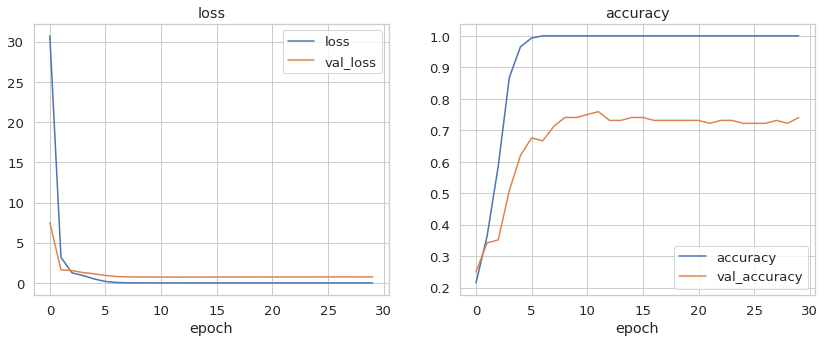

In [19]:
## create & fit the model
batch_size = 32
n_epochs = 30

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          validation_data=(X_val, y_val),
          epochs=n_epochs)

## display accuracy & loss
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(ax=ax1, xlabel='epoch', title='loss')
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(ax=ax2, xlabel='epoch', title='accuracy')
plt.show()

## make & save predictions
predictions = np.argmax(model.predict(X_test), axis=1)
create_submission_file(predictions)

#### **2.4. PCA**
This last landmarks based approach consists of improving the previously proposed approach (Random Forest) by applyinh PCA on landmarks before fitting the Random FOrest.

>**Note:** The number of components to keep by PCA is hypre-parameter to fine-tune !

In [20]:
## extract x & y coordinates of landmarks
x_coords = train_landmarks[:, -1, :, 0]
y_coords = train_landmarks[:, -1, :, 1]
x_coords_test = test_landmarks[:, -1, :, 0]
y_coords_test = test_landmarks[:, -1, :, 1]

## put coordinates in 2D array
X = np.hstack((x_coords, y_coords))
X_test = np.hstack((x_coords_test, y_coords_test))

In [21]:
## create a PCA
pca = PCA(n_components=20)

## apply PCA on data
X_pca = pca.fit_transform(X)
X_test_pca = pca.transform(X_test)

## split the data & make sure expressions are balanced (stratify)
X_train, X_val, y_train, y_val = train_test_split(X_pca, train_labels, test_size=0.2, random_state=42, stratify=train_labels)
print(f'> Number of training samples  : {X_train.shape[0]}')
print(f'> Number of validation samples: {X_val.shape[0]}')

> Number of training samples  : 432
> Number of validation samples: 108


In [22]:
## create & fit a random forest classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

## make & save predictions & evaltuate model
predictions = clf.predict(X_test_pca)
create_submission_file(predictions)

print(f'Accuracy: {clf.score(X_val, y_val)}')

Accuracy: 0.8425925925925926


>**Comment:** Improved !

### ■ **<a name="section3">3. Image-based approaches</a>** [(&#8593;)](#content)
---
#### **3.1. CNN + Last image in a sequence**
The first approach when using images is very obvious, it actually consists of considering only the last image of a sequence and then apply a 2D CNN.

In [23]:
def resize_images(seq, size):
    """to resize images of a given sequence"""
    resized_imgs = []
    for img in seq:
        r_img = cv2.resize(img, size, interpolation = cv2.INTER_NEAREST)
        resized_imgs.append(r_img)
        
    return resized_imgs

## resize images
size = (64, 64)
resized_train_images = np.array([resize_images(seq, size) for seq in train_images])
resized_test_images = np.array([resize_images(seq, size) for seq in test_images])

In [24]:
## take last image in a sequence
X = np.array([seq[-1] for seq in resized_train_images])
X_test = np.array([seq[-1] for seq in resized_test_images])

## onehot encoding
y = tf.keras.utils.to_categorical(train_labels, num_classes=n_expressions)

## split the data & make sure expressions are balanced (stratify)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=train_labels)
print(f'> Number of training samples  : {X_train.shape[0]}')
print(f'> Number of validation samples: {X_val.shape[0]}')

## expand dimensions
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

> Number of training samples  : 432
> Number of validation samples: 108


>**Note:** we will use data augmentation, especially to handle the difference of brightness and contrast between the train and test sets.

In [25]:
## create a data generator
datagen = tf.keras.preprocessing.image.ImageDataGenerator(        
            rotation_range=5,
            width_shift_range=0.2,  
            height_shift_range=0.2,    
            shear_range=0.2,        
            zoom_range=0.2,              
            fill_mode='constant', cval=125)

datagen.fit(X_train)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)       

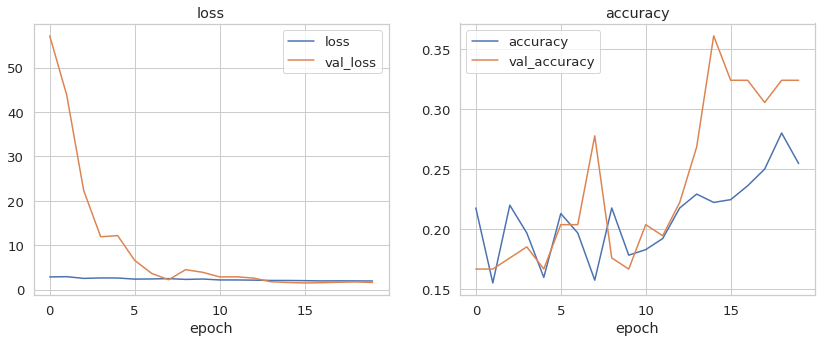

In [26]:
def build_model(input_shape, n_classes):
    #Block-1
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal',input_shape=input_shape))
    model.add(tf.keras.layers.Activation('elu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal',input_shape=input_shape))
    model.add(tf.keras.layers.Activation('elu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Dropout(0.2))
    #Block-2tf.keras.layers.
    model.add(tf.keras.layers.Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal'))
    model.add(tf.keras.layers.Activation('elu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal'))
    model.add(tf.keras.layers.Activation('elu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Dropout(0.2))
    #Block-3tf.keras.layers.
    model.add(tf.keras.layers.Conv2D(128,(3,3),padding='same',kernel_initializer='he_normal'))
    model.add(tf.keras.layers.Activation('elu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(128,(3,3),padding='same',kernel_initializer='he_normal'))
    model.add(tf.keras.layers.Activation('elu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Dropout(0.2))
    #Block-5tf.keras.layers.
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, kernel_initializer='he_normal'))
    model.add(tf.keras.layers.Activation('elu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))
    #Block-6tf.keras.layers.
    model.add(tf.keras.layers.Dense(64, kernel_initializer='he_normal'))
    model.add(tf.keras.layers.Activation('elu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))
    #Block-7tf.keras.layers.
    model.add(tf.keras.layers.Dense(n_expressions, kernel_initializer='he_normal'))
    model.add(tf.keras.layers.Activation('softmax'))
    
    return model

## create & complie the model
_, *input_shape = X_train.shape
model = build_model(input_shape, n_expressions)
model.compile(loss='categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])
model.summary()

## create & fit the model
batch_size = 32
n_epochs = 20
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), 
                              validation_data=(X_val, y_val),
                              epochs=n_epochs)

## display loss & accuracy
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(ax=ax1, xlabel='epoch', title='loss')
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(ax=ax2, xlabel='epoch', title='accuracy')
plt.show()

## make & save predictions
predictions = np.argmax(model.predict(X_test), axis=1)
create_submission_file(predictions)

#### **3.2. Rescaled images + Conv3D**
Now, we try use the whole sequence instead of one images. Then, we will use 3D CNN.

In [27]:
## take last image in a sequence
X = resized_train_images
X_test = resized_test_images

## onehot encoding
y = tf.keras.utils.to_categorical(train_labels, num_classes=n_expressions)

## split the data & make sure expressions are balanced (stratify)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=train_labels)
print(f'> Number of training samples  : {X_train.shape[0]}')
print(f'> Number of validation samples: {X_val.shape[0]}')

## expand dimensions
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

> Number of training samples  : 432
> Number of validation samples: 108


In [28]:
def build_conv3d(inptu_shape, n_classes):
    # Create the model
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv3D(32, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
    model.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2)))
    model.add(tf.keras.layers.Conv3D(64, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2)))
    model.add(tf.keras.layers.Conv3D(128, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.Dense(n_expressions, activation='softmax'))

    return model

Epoch 1/20
14/14 [==============================] - 11s 736ms/step - loss: 4013.5720 - accuracy: 0.1574 - val_loss: 99.5036 - val_accuracy: 0.1667
Epoch 2/20
14/14 [==============================] - 10s 714ms/step - loss: 18.4778 - accuracy: 0.1713 - val_loss: 1.7898 - val_accuracy: 0.1944
Epoch 3/20
14/14 [==============================] - 11s 770ms/step - loss: 1.8047 - accuracy: 0.2037 - val_loss: 1.7781 - val_accuracy: 0.1667
Epoch 4/20
14/14 [==============================] - 10s 719ms/step - loss: 1.7774 - accuracy: 0.2130 - val_loss: 1.7752 - val_accuracy: 0.1944
Epoch 5/20
14/14 [==============================] - 10s 731ms/step - loss: 1.7617 - accuracy: 0.1944 - val_loss: 1.7680 - val_accuracy: 0.2037
Epoch 6/20
14/14 [==============================] - 11s 775ms/step - loss: 1.7456 - accuracy: 0.1852 - val_loss: 1.7781 - val_accuracy: 0.1852
Epoch 7/20
14/14 [==============================] - 10s 722ms/step - loss: 1.7391 - accuracy: 0.1991 - val_loss: 1.7766 - val_accuracy: 0

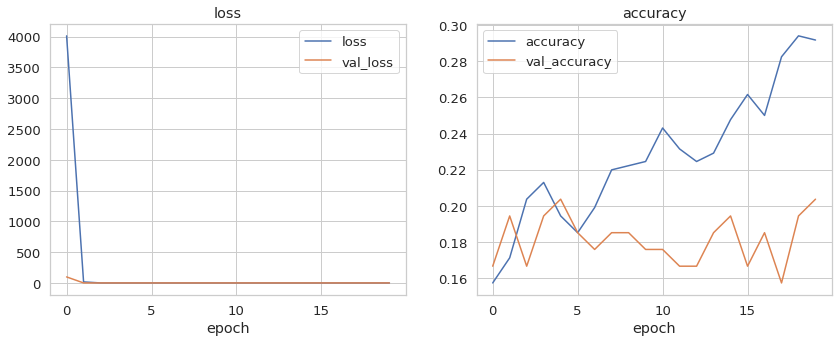

In [29]:
## create & fit a CONV3D model
_, *input_shape = X_train.shape
batch_size = 32
n_epochs = 20

model = build_conv3d(input_shape, n_expressions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    epochs=n_epochs, batch_size=batch_size,  
                    validation_data=(X_val, y_val))

## display loss & accuracy
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(ax=ax1, xlabel='epoch', title='loss')
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(ax=ax2, xlabel='epoch', title='accuracy')
plt.show()

>**Comment:** More accurate than the previous one !

#### **3.3. Optical Flow + Conv3D**
We compute the optical flow over the sequence by considering the change between all images with respect to the last one (last one contains clair expressions while first images do not contain expressions).
>**Note:** The optical flow of an expressions is mostly independant of the subjects, this is more suitable to consider for such problems.

In [30]:
def compute_optical_flow(img_seq):
    """to compute optical flow of a given sequence"""
    
    ## last images
    frame_2 = img_seq[-1]
    
    flows = []
    
    for frame_1 in img_seq[:-1]:
        ## Calculates dense optical flow by Farneback method
        flow = cv2.calcOpticalFlowFarneback(frame_1, frame_2,  None, 0.5, 3, 15, 3, 5, 1.2, 0)

        # Computes the magnitude and angle of the 2D vectors
        mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        flow = np.zeros((img_seq.shape[-2], img_seq.shape[-1], 2))
        ## clipping
        mag[mag > 1] = 1.

        ## normalization
        flow[..., 0] = mag
        flow[..., 1] = ang / (2 * np.pi)
        flows.append(flow)
        
    return flows

In [31]:
## optical flow
X = np.array([compute_optical_flow(seq) for seq in resized_train_images])
X_test = np.array([compute_optical_flow(seq) for seq in resized_test_images])

## onehot encoding
y = tf.keras.utils.to_categorical(train_labels, num_classes=n_expressions)

## split the data & make sure expressions are balanced (stratify)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=train_labels)
print(f'> Number of training samples  : {X_train.shape[0]}')
print(f'> Number of validation samples: {X_val.shape[0]}')

> Number of training samples  : 432
> Number of validation samples: 108


Epoch 1/20
14/14 [==============================] - 10s 656ms/step - loss: 32.7941 - accuracy: 0.2037 - val_loss: 2.0442 - val_accuracy: 0.3056
Epoch 2/20
14/14 [==============================] - 9s 644ms/step - loss: 2.0413 - accuracy: 0.4005 - val_loss: 2.3512 - val_accuracy: 0.2963
Epoch 3/20
14/14 [==============================] - 9s 641ms/step - loss: 0.9464 - accuracy: 0.6829 - val_loss: 1.0555 - val_accuracy: 0.5741
Epoch 4/20
14/14 [==============================] - 9s 657ms/step - loss: 0.3583 - accuracy: 0.9236 - val_loss: 1.0164 - val_accuracy: 0.5833
Epoch 5/20
14/14 [==============================] - 9s 635ms/step - loss: 0.1538 - accuracy: 0.9699 - val_loss: 0.8846 - val_accuracy: 0.6759
Epoch 6/20
14/14 [==============================] - 9s 637ms/step - loss: 0.0529 - accuracy: 0.9954 - val_loss: 0.9433 - val_accuracy: 0.6574
Epoch 7/20
14/14 [==============================] - 10s 692ms/step - loss: 0.0195 - accuracy: 1.0000 - val_loss: 0.9929 - val_accuracy: 0.6481
Epo

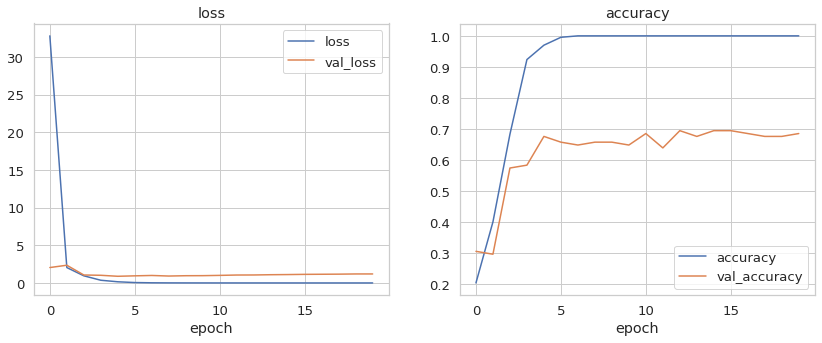

In [32]:
def build_conv3d(inptu_shape, n_classes):
    # Create the model
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv3D(32, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
    model.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2)))
    model.add(tf.keras.layers.Conv3D(64, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.Dense(n_expressions, activation='softmax'))

    return model

# Compile the model
_, *input_shape = X_train.shape
model = build_conv3d(input_shape, n_expressions)
model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer='nadam', metrics=['accuracy'])

# Fit data to model
history = model.fit(X_train, y_train,
                    batch_size=batch_size, epochs=n_epochs,
                    validation_data=(X_val, y_val))

## dispaly loss & accuracy
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(ax=ax1, xlabel='epoch', title='loss')
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(ax=ax2, xlabel='epoch', title='accuracy')
plt.show()

## make & save predictions
predictions = np.argmax(model.predict(X_test), axis=1)
create_submission_file(predictions)

>**Comment:** Better than all previously proposed image-based approaches!

### ■ **<a name="section4">4. Perspectives</a>** [(&#8593;)](#content)
---

1. Try to harmonize the train and test sets in terms of brightness, contrast and background' color.

2. Determine the directions of variation of each landmarks (up, down, right and left) and use ensembe techniques (e.g. Random Forest).

3. Cluster landmarks over time, i.e., compute the center and the range of variation of each landmarks over times. Each landmark will be in a circle with center $a$ and radius $r$.

4. Model landmarks in a graph where nodes are landmarks and edges is the distance between each pair of landmarks then use a GNN.

5. Apply PCA on landmarks.

5. Combine models that make predictions from both landmarks & images, then use the majority vote techinque.

6. Transfer Learning, finefuning (for example using Bayesian optimization).

7. Try various pre-trained model: ResNet, I3D, etc.

8. Apply Discrete Cosine Transformation on images.